## Dependencies 

In [1]:
# Import dependencies

import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error

from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error

import seaborn as sns
from math import sqrt

import pandas as pd
import numpy as np
from config import password


In [2]:
# Database dependencies
import psycopg2
import sqlalchemy
from sqlalchemy import create_engine

# Database credentials
DATABASES = {
    'finalproject':{
        'POSTGRES_ADDRESS' :'finalproject.c969jxlkzz2v.us-east-2.rds.amazonaws.com',
        'POSTGRES_PORT' : '5432',
        'POSTGRES_USERNAME' : "postgres",
        'POSTGRES_PASSWORD' : password,
        'POSTGRES_DBNAME' : 'housingdata',
    },
}

# Choose the database to use
db = DATABASES['finalproject']

# Connect to postgres
postgres_str = ('postgresql+psycopg2://{username}:{password}@{ipaddress}:{port}/{dbname}'
               .format(username= db['POSTGRES_USERNAME'],
                      password= db['POSTGRES_PASSWORD'],
                      ipaddress= db['POSTGRES_ADDRESS'],
                      port= db['POSTGRES_PORT'],
                      dbname= db['POSTGRES_DBNAME'])
               )

# Create an database engine instance
connection = create_engine(postgres_str)

## Load the datasets

In [3]:
df = pd.read_sql_table('final_table', connection)
df.head()

,city,zhvi,total_pop,med_income,med_age,male,female,race_w,race_aa,race_nat,...,murder_mansl,rape,robbery,agg_assault,burglary,lar_theft,car_theft,arson,lat,long
0,Ladd,86540.17,1185.0,65972.0,42.9,587.0,598.0,1133.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,41.382535,-89.218975
1,Lake Bluff,459437.17,10003.0,107039.0,42.7,4642.0,5361.0,8616.0,151.0,62.0,...,0.0,0.0,1.0,0.0,7.0,36.0,0.0,0.0,42.278912,-87.834236
2,Lake Forest,808297.42,21131.0,171913.0,46.6,10472.0,10659.0,18890.0,520.0,94.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.258634,-87.840625
3,Lake Villa,208693.58,35286.0,96024.0,40.3,17646.0,17640.0,32294.0,900.0,131.0,...,1.0,4.0,0.0,4.0,3.0,29.0,1.0,0.0,42.416965,-88.073971
4,Lake Zurich,429947.17,42637.0,135146.0,42.0,21299.0,21338.0,36357.0,1008.0,145.0,...,0.0,1.0,1.0,3.0,18.0,238.0,3.0,0.0,42.196969,-88.093411


## Data preprocessing

In [4]:
clean_df = df.drop(['city','lat','long', 'male','female', 'eth_nonhisp','murder_mansl', 'robbery','arson','rape', 'car_theft','rape','burglary'],1)
clean_df.head()

,zhvi,total_pop,med_income,med_age,race_w,race_aa,race_nat,race_as,race_api,race_oth,eth_hisp,agg_assault,lar_theft
0,86540.17,1185.0,65972.0,42.9,1133.0,0.0,0.0,7.0,0.0,49.0,83.0,3.0,2.0
1,459437.17,10003.0,107039.0,42.7,8616.0,151.0,62.0,1207.0,0.0,129.0,762.0,0.0,36.0
2,808297.42,21131.0,171913.0,46.6,18890.0,520.0,94.0,1836.0,7.0,142.0,1013.0,0.0,0.0
3,208693.58,35286.0,96024.0,40.3,32294.0,900.0,131.0,1733.0,17.0,858.0,3137.0,4.0,29.0
4,429947.17,42637.0,135146.0,42.0,36357.0,1008.0,145.0,5008.0,124.0,868.0,3441.0,3.0,238.0


In [5]:
clean_df.describe()

,zhvi,total_pop,med_income,med_age,race_w,race_aa,race_nat,race_as,race_api,race_oth,eth_hisp,agg_assault,lar_theft
count,9.790000e+02,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.00000,979.000000,979.000000,979.000000,979.000000,979.000000
mean,1.374120e+05,7628.810429,62588.514917,42.351034,6170.608401,772.398683,53.678888,422.29714,8.344211,385.104208,1054.550669,25.935649,149.924413
std,1.178790e+05,11587.889998,21145.745980,5.858168,8906.665564,2649.138961,103.762227,1262.54303,24.359187,1965.207884,3744.702529,493.154123,2084.391414
min,1.852242e+04,58.000000,16023.000000,21.500000,58.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.388796e+04,819.500000,49696.000000,38.650000,792.000000,1.000000,0.000000,0.00000,0.000000,0.000000,7.000000,0.000000,0.000000
50%,9.960942e+04,1995.000000,58289.000000,42.000000,1918.000000,22.000000,9.000000,11.00000,0.000000,8.000000,39.000000,0.000000,0.000000
75%,1.601418e+05,9741.500000,70160.000000,45.700000,7515.500000,242.500000,51.500000,121.00000,2.000000,116.000000,481.000000,4.000000,31.500000
max,1.360530e+06,83147.000000,212750.000000,63.500000,49654.000000,30695.000000,734.000000,9528.50000,256.000000,47835.000000,74180.000000,15312.000000,64695.000000


In [6]:
# Split our preprocessed data into our features and target arrays
y = clean_df['zhvi']
X = clean_df.drop(['zhvi'], 1)

## Linear Regression

In [7]:
# Initiate Linear regression
model = KNeighborsRegressor()
model.fit(X,y)
predictions = model.predict(X)
print(type(model).__name__)
print(" MAE", mean_absolute_error(y,predictions))
print(" RMSE", sqrt(mean_squared_error(y,predictions)))
print(" R2", r2_score(y, predictions))


KNeighborsRegressor
 MAE 26190.16925042103
 RMSE 42998.6266972307
 R2 0.8668074155383965


--------------A Multicollinearity plot---------------


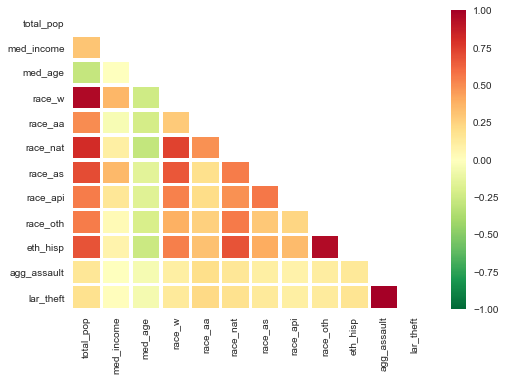

In [8]:
# Check for multicollinearity
corr_df = X.corr(method='pearson')
print("--------------A Multicollinearity plot---------------")

#Create a mask to display only the lower triangle of the matrix(since it mirrored around its top-left to bottom-right diagonal)
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True

#Create the heatmap using seaborn library
sns.heatmap(corr_df, cmap='RdYlGn_r', vmax=1.0, vmin=-1.0, mask= mask, linewidths=2.5)
# Show the plot. We reorient the labels for each column and row to make them easier to read.
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

In [9]:
# Predict
y_pred = model.predict(X)

In [10]:
results = pd.DataFrame({"Prediction": y_pred, "Actual": y}).reset_index(drop=True)
results.head(20)

,Prediction,Actual
0,106097.432,86540.17
1,489532.200,459437.17
2,848294.434,808297.42
3,305508.301,208693.58
4,463303.750,429947.17
5,75986.434,94631.75
6,117638.916,195972.25
7,126538.140,123031.58
8,81684.250,95756.92
9,98724.050,67263.00


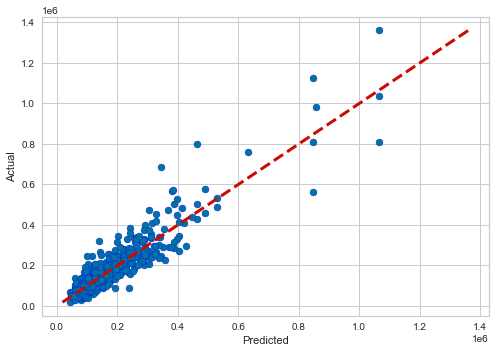

In [11]:
fig, ax = plt.subplots()
ax.scatter(y_pred, y, edgecolors=(0, 0, 1))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=3)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

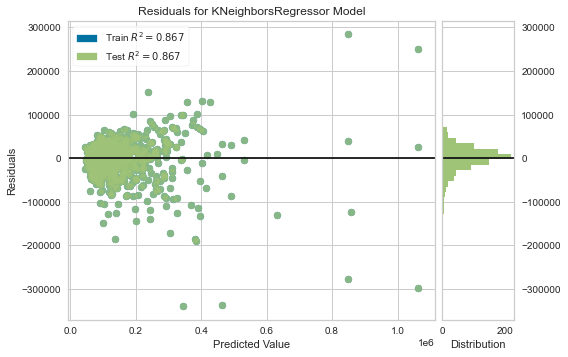

In [12]:
# Create the visualizer, fit, score, and show it
viz = residuals_plot(KNeighborsRegressor(), X, y)

In [13]:
# # List the features sorted in descending order by feature importance
# features = (sorted(zip(model.feature_importances_, X.columns), reverse=True))

# vals = [f for f,x in features]
# names = [x for f,x in features]

# plt.barh(names, vals)
# plt.xlabel("Random Forest Feature Importance")

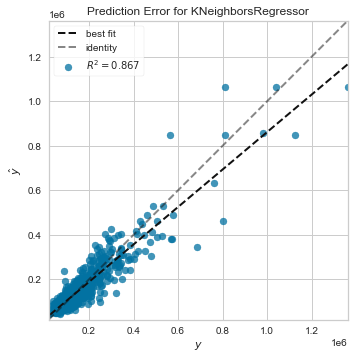

In [14]:
# Instantiate the linear model and visualizer
visualizer = prediction_error(model, X, y)

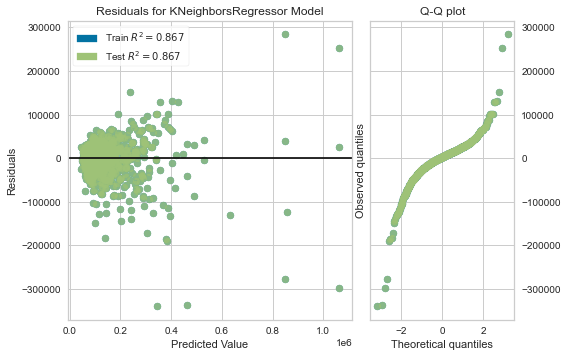

In [15]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(model, hist=False, qqplot=True)
visualizer.fit(X, y)
visualizer.score(X, y)
visualizer.show()

/Users/jacob/opt/anaconda3/envs/PythonData/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


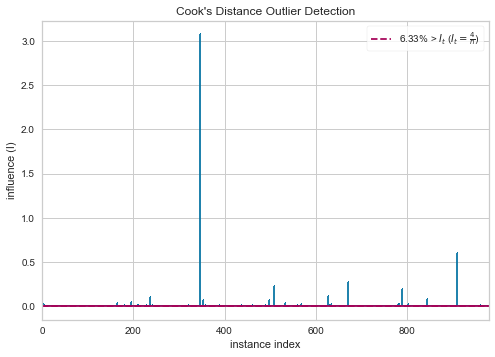

CooksDistance(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fb4d9f885b0>)

In [25]:
from yellowbrick.regressor import cooks_distance
# Instantiate and fit the visualizer
cooks_distance(
    X, y,
    draw_threshold=True,
    linefmt="C0-", markerfmt=","
)